<a href="https://colab.research.google.com/github/apurba420/Cassava_Leaf_Classification-traing_on_TPU/blob/main/Tansfer%20Learning%20using%20VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fsspec
!pip install gcsfs

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import keras
from keras.regularizers import l2
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import NASNetMobile

**Activate TPU accelerator**

In [ ]:
def auto_select_accelerator():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return strategy

In [ ]:
strategy = auto_select_accelerator()

INFO:tensorflow:Initializing the TPU system: grpc://10.59.180.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.59.180.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU: grpc://10.59.180.170:8470
Running on 8 replicas


In [ ]:
GCS_DS_PATH = 'gs://kds-e118bcdb309cf88b7f9e4a96ee84997123a5781b886180ffc13d3fc9'

In [ ]:
df = pd.read_csv(GCS_DS_PATH +'/train.csv')
sub_df = pd.read_csv(GCS_DS_PATH +'/sample_submission.csv')
train_path = "gs://kds-e118bcdb309cf88b7f9e4a96ee84997123a5781b886180ffc13d3fc9/train_images/"


In [ ]:
new = {0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [ ]:
df['label'] = df['label'].map(new)

In [ ]:
df

,image_id,label
0,1000015157.jpg,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,Cassava Mosaic Disease (CMD)
2,100042118.jpg,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,Cassava Mosaic Disease (CMD)
...,...,...
21392,999068805.jpg,Cassava Mosaic Disease (CMD)
21393,999329392.jpg,Cassava Mosaic Disease (CMD)
21394,999474432.jpg,Cassava Brown Streak Disease (CBSD)
21395,999616605.jpg,Healthy


In [ ]:
train, test = train_test_split(df, test_size = 0.15, random_state = 42, stratify = df['label'])

In [ ]:
img_size = 256
batch_size = strategy.num_replicas_in_sync * 16

In [ ]:
datagen_train = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.nasnet.preprocess_input,
    rotation_range = 60,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
)

datagen_val = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.nasnet.preprocess_input,
)

In [ ]:
train_set = datagen_train.flow_from_dataframe(
    train,
    directory=train_path,
    seed=42,
    x_col='image_id',
    y_col='label',
    target_size = (img_size,img_size),
    class_mode='categorical',
    interpolation='nearest',
    shuffle = True,
    batch_size = batch_size,
)

Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 18187 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


**Google Cloud Bucket Link**

**Read the CSV file**


In [ ]:
df

,image_id,label
0,1000015157.jpg,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,Cassava Mosaic Disease (CMD)
2,100042118.jpg,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,Cassava Mosaic Disease (CMD)
...,...,...
21392,999068805.jpg,Cassava Mosaic Disease (CMD)
21393,999329392.jpg,Cassava Mosaic Disease (CMD)
21394,999474432.jpg,Cassava Brown Streak Disease (CBSD)
21395,999616605.jpg,Healthy


In [ ]:
labels = df["label"]

**Train test split**

In [ ]:
(
    train_paths, valid_paths, 
    train_labels, valid_labels
) = train_test_split(paths, labels, test_size=0.25, random_state=42, stratify=labels)

In [ ]:
decoder = build_decoder(with_labels=True, target_size=(img_size, img_size))
test_decoder = build_decoder(with_labels=False, target_size=(img_size, img_size))

train_dataset = build_dataset(
    train_paths, train_labels, bsize=batch_size, decode_fn=decoder
)

valid_dataset = build_dataset(
    valid_paths, valid_labels, bsize=batch_size, decode_fn=decoder,
    repeat=False, shuffle=False, augment=False
)

test_dataset = build_dataset(
    test_paths, cache=False, bsize=batch_size, decode_fn=test_decoder,
    repeat=False, shuffle=False, augment=False
)

In [ ]:
train_dataset

<PrefetchDataset shapes: ((None, 331, 331, 3), (None,)), types: (tf.float32, tf.int64)>

In [ ]:
with strategy.scope():
    model = tf.keras.Sequential([
                                   tf.keras.applications.VGG16(
          include_top=False,
      weights="imagenet",
      input_shape=(331,331,3)),
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.Dense(5, activation='softmax')
      ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0001), metrics=['acc'])
    model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 10, 10, 512)       14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
activation_260 (Activation)  (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total params: 14,719,301
Trainable params: 14,718,277
Non-trainable params: 1,024
_________________________________________________________________


In [ ]:
steps_per_epoch = train_paths.shape[0] // batch_size
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'Model5.h5', save_best_only=True, monitor='val_loss', mode='min')
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", patience=1, min_lr=1e-3, mode='min')

In [ ]:
history = model.fit(
    train_dataset, 
    epochs=4,
    steps_per_epoch=steps_per_epoch,callbacks = [checkpoint, lr_reducer],
    validation_data=valid_dataset)

Epoch 1/4
250/250 [==============================] - 53s 212ms/step - loss: 0.2623 - acc: 0.9104 - val_loss: 0.4228 - val_acc: 0.8751
Epoch 2/4
250/250 [==============================] - 53s 212ms/step - loss: 0.2530 - acc: 0.9167 - val_loss: 0.4250 - val_acc: 0.8652
Epoch 3/4
250/250 [==============================] - 53s 211ms/step - loss: 0.2505 - acc: 0.9151 - val_loss: 0.4190 - val_acc: 0.8712
Epoch 4/4
 94/250 [==========>...................] - ETA: 29s - loss: 0.2599 - acc: 0.9114

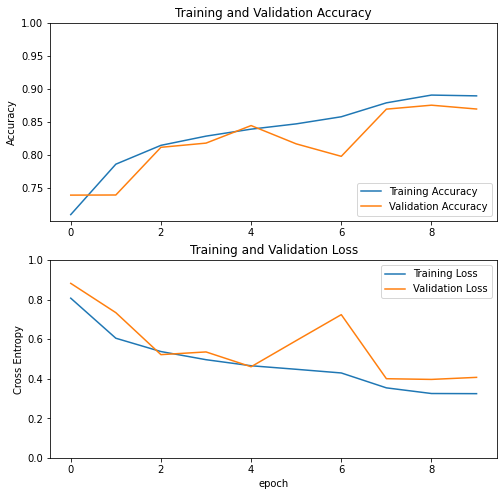

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()